In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
# import numpy as np
import pandas as pd

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds
import autograd.numpy as np




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [4]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [5]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [139]:
def cost_feature(H, A, T, H_1, F, E_np_masked, static, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    HF = np.einsum('na,ab->nb', H_1, F)
    mask_static = ~np.isnan(static)
    error_2 = (HF - static)[mask_static].flatten()
    
    return np.sqrt((error_1**2).mean()) + np.sqrt((error_2**2).mean())

In [140]:
def learn_HAT_adagrad_feature(case, E_np_masked, static, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    cost = cost_feature
    mg = multigrad(cost, argnums=[0, 1, 2, 3, 4])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)
    H_1 = np.random.rand(params['M'], 2)
    F = np.random.rand(2,3)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)
    sum_square_gradients_H_1 = np.zeros_like(H_1)
    sum_square_gradients_F = np.zeros_like(F)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    H_1s = [H_1.copy()]
    Fs = [F.copy()]
    
    if 'penalty' not in cost_function:
        costs = [cost(H, A, T, H_1, F, E_np_masked, static, case)]
    else:
        costs = [cost(H, A, T, E_np_masked, 2, penalty_coeff)]
    HATs = [multiply_case(H, A, T, 2)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t, del_h_1, del_f = mg(H, A, T, H_1, F, E_np_masked, static, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)
        sum_square_gradients_H_1 += eps + np.square(del_h_1)
        sum_square_gradients_F += eps + np.square(del_f)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))
        lr_h_1 = np.divide(lr, np.sqrt(sum_square_gradients_H_1))
        lr_f = np.divide(lr, np.sqrt(sum_square_gradients_F))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        H_1 -= lr_h_1 * del_h_1
        F -= lr_f * del_f
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        H = set_known(H, H_1)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8
        H_1[H_1 < 0] = 1e-8
        F[F < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        H_1s.append(H_1.copy())
        Fs.append(F.copy())
        if 'penalty' not in cost_function:
            costs.append(cost(H, A, T, H_1, F, E_np_masked, static, case))
        else:
            costs.append(cost(H, A, T, F, E_np_masked, static, case))
        HATs.append(multiply_case(H, A, T, 2))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, H_1, F, E_np_masked, static, case))
    return H, A, T, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs




In [141]:
def learn_HAT_feature(case, E_np_masked, static, sim, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None, random_seed=0, decay_mul=1, batchsize=None, aggregate_constraint=False):

    np.random.seed(random_seed)
    lrs = lr*np.power(decay_mul, range(num_iter))
    
    cost = cost_graph_test
    mg = multigrad(cost, argnums=[0, 1, 2, 3, 4])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    
    H = np.abs(np.random.rand(*H_dim))
    A = np.abs(np.random.rand(*A_dim))
    T = np.abs(np.random.rand(*T_dim))
    H_1 = np.abs(np.random.rand(params['M'], 2))
    F = np.abs(np.random.rand(2, 3))

    if batchsize is None:
        batchsize = len(E_np_masked)

    indices_home = range(params['M'])


    # GD procedure
    for i in range(num_iter):
        if batchsize < len(E_np_masked):
            indices_select = np.random.choice(indices_home, batchsize)
            del_h, del_a, del_t, del_h1, del_f = mg(H[indices_select], A, T, H_1, F, E_np_masked[indices_select], static, sim, case)
            H[indices_select] -= lrs[i] * del_h
        else:
            del_h, del_a, del_t, del_h1, del_f = mg(H, A, T, H_1, F, E_np_masked, static,case)
            H -= lrs[i] * del_h
        
        A -= lrs[i] * del_a
        T -= lrs[i] * del_t
        H_1 -= lrs[i] * del_h1
        F -= lrs[i] * del_f
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        H = set_known(H, H_1)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        H_1[H_1 < 0] = 0
        F[F < 0] = 0


        if aggregate_constraint:
            # Projection to ensure A[aggregate] >=sum(A[appliances]
            A[0] = np.maximum(A[0], np.sum(A[1:], axis=0))

        if i % 100 == 0:
            if dis:
                print(cost(H, A, T, H_1, F, E_np_masked, static,case), lrs[i], i)
    return H, A, T, F

In [142]:
n_splits = 10
case = 2
a = 5
b = 3
c = 1
cost = 'abs'
iters = 2000

# H_au, A_au, T_au, F_au = learn_HAT_graph(2, au_tensor, static_au, sim_au, a, b, num_iter=iters, dis=True, T_known = np.ones(12).reshape(-1, 1))
H_au, A_au, T_au, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs = learn_HAT_adagrad_feature(2, au_tensor, static_au, a, b, num_iter=iters, dis=False, T_known = np.ones(12).reshape(-1, 1))
H_au_ada, A_au_ada, T_au_ada, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='l21', H_known = static_au, T_known=np.ones(12).reshape(-1, 1))


pred_normal = {}
pred_transfer = {}
pred_normal_old = {}
pred_transfer_old = {}
for random_seed in range(10):
    pred_normal[random_seed] = {}
    pred_transfer[random_seed] = {}
    pred_normal_old[random_seed] = {}
    pred_transfer_old[random_seed] = {}
    
    
    for appliance in APPLIANCES_ORDER:
        pred_normal[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}
        pred_normal_old[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}
        pred_transfer_old[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    np.random.seed(random_seed)
    for train_percentage in range(10, 110, 20):
        print "training percentage: ", train_percentage
        rd = 0
        
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
           
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            
            
            ############################################################################################
            # Normal learning: no constant constraint, no A_known, with learn_HAT
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='l21', H_known = static_sd[np.concatenate([test, train])], T_known=np.ones(12).reshape(-1, 1))
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal_old[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
                       
            
            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, A_known = A_au, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='l21', H_known = static_sd[np.concatenate([test, train])], A_known = A_au_ada, T_known=np.ones(12).reshape(-1, 1))
            

            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer_old[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            ############################################################################################
            # Normal learning: no constant constraint, no A_known, with learn_HAT
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs = learn_HAT_adagrad_feature(2, tensor_copy, static_sd[np.concatenate([test, train])], a, b, num_iter=iters,dis=False, T_known = np.ones(12).reshape(-1, 1))
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
                       
            
            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, A_known = A_au, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs = learn_HAT_adagrad_feature(2, tensor_copy, static_sd[np.concatenate([test, train])], a, b, num_iter=iters,dis=False, A_known = A_au, T_known = np.ones(12).reshape(-1, 1))


            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  30
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  50
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909,

round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  70
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114,

round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  90
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370,

round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
random seed:  9
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  30
round:  0
test

In [144]:
out = {}

out_normal = {}
out_transfer = {}
out_normal_old = {}
out_transfer_old = {}

for random_seed in range(10):
    out_normal[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal[random_seed][appliance] = {}
        for f in range(10,110,20):
            s = pd.concat(pred_normal[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
print "finish one"
for random_seed in range(10):
    out_transfer[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,20):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
print "finish one"
for random_seed in range(10):
    out_normal_old[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal_old[random_seed][appliance] = {}
        for f in range(10,110,20):
            s = pd.concat(pred_normal_old[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal_old[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal_old[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
print "finish one"
for random_seed in range(10):
    out_transfer_old[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_old[random_seed][appliance] = {}
        for f in range(10,110,20):
            s = pd.concat(pred_transfer_old[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_old[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_old[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

finish one
finish one
finish one


In [145]:
mean_out_normal_old = pd.Panel(out_normal_old).mean(axis=0)
mean_out_transfer_old = pd.Panel(out_transfer_old).mean(axis=0)
mean_out_normal = pd.Panel(out_normal).mean(axis=0)
mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)

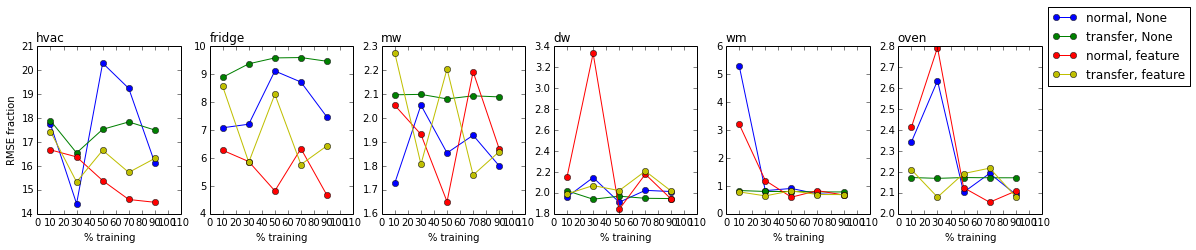

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
algo = 'adagrad'

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out_normal_old[appliance]
    df2 = mean_out_transfer_old[appliance]
    df3 = mean_out_normal[appliance]
    df4 = mean_out_transfer[appliance]
   
    df = pd.concat([df1, df2, df3, df4], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle(algo, fontsize=17,y=1.04)


ax[count-1].legend(['normal, None', 'transfer, None', 'normal, feature', 'transfer, feature' ], loc='center left' , bbox_to_anchor=(1, 1))
# plt.savefig("./analysis/08/test1.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [119]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        try:
            return pickle.load(f)
        except EOFError:
            return None

In [121]:
result = {}
pred= {}
param = {}
for method in ['normal', 'transfer']:
    pred[method] = {}
    param[method] = {}
    for feature_fac in ['feature', 'None']:
        pred[method][feature_fac] = {}
        param[method][feature_fac] = {}
        for random_seed in range(5):
            pred[method][feature_fac][random_seed] = {}
            param[method][feature_fac][random_seed] = {}
            for train_percentage in range(10, 110, 20):
                name = "pred_feature/{}_{}/{}-{}-{}".format(method, feature_fac, feature_fac, random_seed, float(train_percentage))
                print name
                r = load_obj(name)
                pred[method][feature_fac][random_seed][train_percentage] = r['Predictions']
                param[method][feature_fac][random_seed][train_percentage] = r['Learning Params']

pred_feature/normal_feature/feature-0-10.0
pred_feature/normal_feature/feature-0-30.0
pred_feature/normal_feature/feature-0-50.0
pred_feature/normal_feature/feature-0-70.0
pred_feature/normal_feature/feature-0-90.0
pred_feature/normal_feature/feature-1-10.0
pred_feature/normal_feature/feature-1-30.0
pred_feature/normal_feature/feature-1-50.0
pred_feature/normal_feature/feature-1-70.0
pred_feature/normal_feature/feature-1-90.0
pred_feature/normal_feature/feature-2-10.0
pred_feature/normal_feature/feature-2-30.0
pred_feature/normal_feature/feature-2-50.0
pred_feature/normal_feature/feature-2-70.0
pred_feature/normal_feature/feature-2-90.0
pred_feature/normal_feature/feature-3-10.0
pred_feature/normal_feature/feature-3-30.0
pred_feature/normal_feature/feature-3-50.0
pred_feature/normal_feature/feature-3-70.0
pred_feature/normal_feature/feature-3-90.0
pred_feature/normal_feature/feature-4-10.0
pred_feature/normal_feature/feature-4-30.0
pred_feature/normal_feature/feature-4-50.0
pred_featur

In [133]:
pd.DataFrame(pred['normal']['feature'][0])
pred['normal']['feature'][0][10]['hvac']

,0,1,2,3,4,5,6,7,8,9,10,11
54,2.159033e+02,1.963362e+02,2.083000e+02,2.376782e+02,2.719902e+02,2.536889e+02,3.275480e+02,3.436213e+02,3.592188e+02,2.039878e+02,2.226204e+02,2.623359e+02
203,6.030775e+02,5.446119e+02,5.828655e+02,6.660978e+02,7.352725e+02,6.705680e+02,9.026296e+02,9.239305e+02,9.740377e+02,5.283749e+02,6.112541e+02,7.116953e+02
527,2.610334e+02,2.396188e+02,2.510721e+02,2.959066e+02,3.630947e+02,3.584149e+02,4.704509e+02,4.821730e+02,4.838491e+02,2.760096e+02,2.885317e+02,3.479184e+02
1450,5.495758e+02,4.984741e+02,5.302617e+02,6.245895e+02,7.219434e+02,6.888156e+02,9.581834e+02,9.496402e+02,9.660407e+02,5.146460e+02,5.882216e+02,6.956453e+02
1524,3.786871e+02,8.682486e+00,1.021201e+01,1.232872e+02,5.388664e+02,4.754271e+02,5.825962e+02,7.167486e+02,6.181163e+02,7.204119e+01,9.684661e+01,6.572428e+01
1731,1.643483e+02,3.874415e+00,4.556942e+00,6.962478e+01,2.592725e+02,2.073615e+02,4.073139e+02,4.650988e+02,5.175318e+02,2.607542e+02,2.394735e+02,2.475456e+02
2031,8.252669e+01,1.751583e+00,2.060146e+00,3.150342e+01,1.249946e+02,1.039481e+02,1.728472e+02,2.020334e+02,2.087508e+02,8.369756e+01,7.968984e+01,7.927981e+01
2354,1.107811e+02,1.845794e+00,2.170954e+00,5.221420e+01,1.842780e+02,1.403141e+02,3.320037e+02,3.711677e+02,4.415702e+02,2.603261e+02,2.345559e+02,2.478479e+02
2606,1.630478e+01,1.315963e+01,1.541674e+01,2.863344e+01,9.760470e+01,3.349176e+01,1.634403e+02,1.541321e+02,1.606403e+02,5.619333e+01,1.673049e+01,2.063746e+01
3687,1.025499e+02,7.206428e+01,9.216616e+01,1.312105e+02,3.585099e+02,1.773794e+02,5.508761e+02,5.476799e+02,6.578005e+02,2.789337e+02,1.175740e+02,1.347983e+02


In [134]:
out= {}
for method in ['normal', 'transfer']:
    out[method] = {}
    for feature_fac in ['feature', 'None']:
        out[method][feature_fac] = {}
        for random_seed in range(5):
            out[method][feature_fac][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out[method][feature_fac][random_seed][appliance] = {}
                for f in range(10,110,20):
#                     s = pd.concat(pred[method][feature_fac][random_seed][appliance][f]).ix[sd_df.index]
                    s = pred[method][feature_fac][random_seed][f][appliance]
                    if appliance=="hvac":
                        out[method][feature_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out[method][feature_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
            

In [136]:
mean_out = {}
for method in ['normal', 'transfer']:
    mean_out[method] = {}
    for feature_fac in ['feature', 'None']:
        mean_out[method][feature_fac] = pd.Panel(out[method][feature_fac]).mean(axis=0)

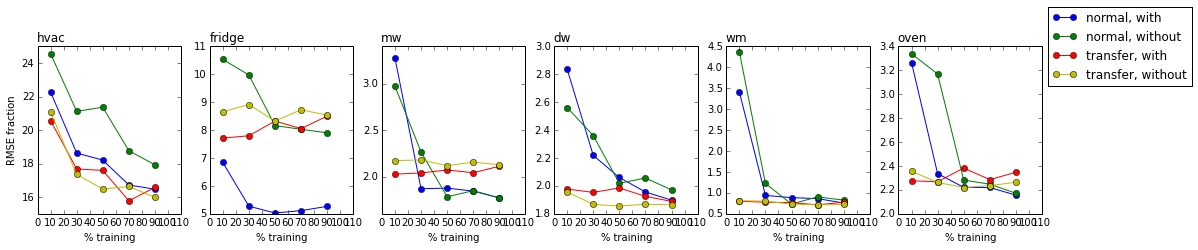

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
algo = 'gd'

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out['normal']['feature'][appliance]
    df2 = mean_out['normal']['None'][appliance]
    df3 = mean_out['transfer']['feature'][appliance]
    df4 = mean_out['transfer']['None'][appliance]
    df = pd.concat([df1, df2, df3, df4], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle(algo, fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["normal, with", 'normal, without', 'transfer, with', 'transfer, without'], loc='center left' , bbox_to_anchor=(1, 1))
plt.savefig("./analysis/08/featurefactorization_all.pdf", bbox_inches="tight", dpi=300, format='pdf')